# Show some basics and options for the retrieval
This notebooks reads a sample spectra and illustrates the retrieval of the PSD similar to Barret et al. (2019) and some sensitivities for the particle properties

In [1]:
from PSDretrieval import processRadar as pR
from PSDretrieval import plotting as pl
from PSDretrieval import scattering as sc
from PSDretrieval import retrievalUtils as rU
import snowScatt
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#load sample from data
#date = "20190113"
#time = "06:18:04"
#hcenter=2000 #[m]
#load data (this is a window of time and height, which can define by additional input parameters)
#SpecWindow  = pR.loadSpectra(loadSample=False,dataPath="/data/obs/campaigns/tripex-pol/processed/",createSample=True,date=date,time=time,tRange=1,hRange=180,hcenter=hcenter)
#load the Spectral Window
#PeaksWindow  = pR.loadPeaks(loadSample=False,dataPath="/data/obs/campaigns/tripex-pol/spectralPeaks/",createSample=True,date=date,time=time,tRange=1,hRange=180,hcenter=hcenter)

In [2]:
#load sample data (this is a window of time and height, which can define by additional input parameters)
SpecWindow  = pR.loadSpectra()
#extract a single spectra from the time-height window
SpecSingle  = pR.selectSingleTimeHeight(SpecWindow)
#load detected peaks from processed file
PeaksWindow  = pR.loadPeaks()

## plot the sample spectrum

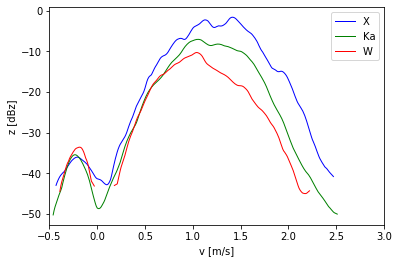

In [3]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax = pl.plotObsSpectra(SpecSingle,ax)

## get the vertical wind estimate

In [4]:
#add vertical wind information to 
SpecWindow = pR.addVerticalWindToSpecWindow(SpecWindow,PeaksWindow)
#extract a single spectra from the time-height window (no with the W-information)
SpecSingle  = pR.selectSingleTimeHeight(SpecWindow)
#get again the - now shifted - single spectra from the SpecWindow 
SpecSingleWshifted  = pR.shiftSpectra(SpecSingle)

TODO: this lines should be checked with a time period with two peaks


In [20]:
## alternatively: set w yourself

In [ ]:
SpecWindow = pR.addVerticalWindToSpecWindow(SpecWindow,None,addManually=True,manualW=0.5)

## plot W-shifted spectra

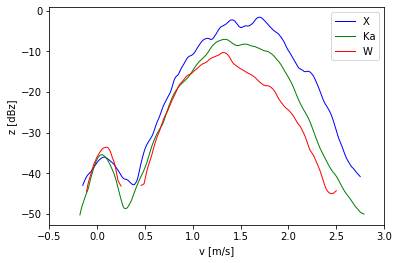

In [5]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax = pl.plotObsSpectra(SpecSingleWshifted,ax)

## cut noisy part and plot spectra again

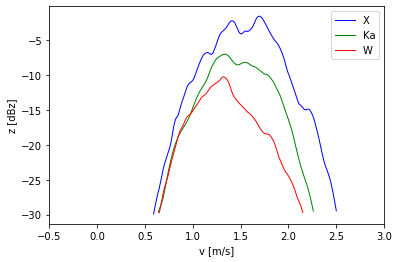

In [16]:
fig,ax = plt.subplots(nrows=1,ncols=1)
#cut spectra
zeThreshold=-30
SpecWindow = pR.cutLowZe(SpecWindow,zeThreshold=zeThreshold)
SpecSingleWshiftedCut = pR.cutLowZe(SpecSingleWshifted.copy(),zeThreshold=zeThreshold)
ax = pl.plotObsSpectra(SpecSingleWshiftedCut,ax)

## plot single-spectra DV vs. DWR

plot DV vs DWR for a single spectrum


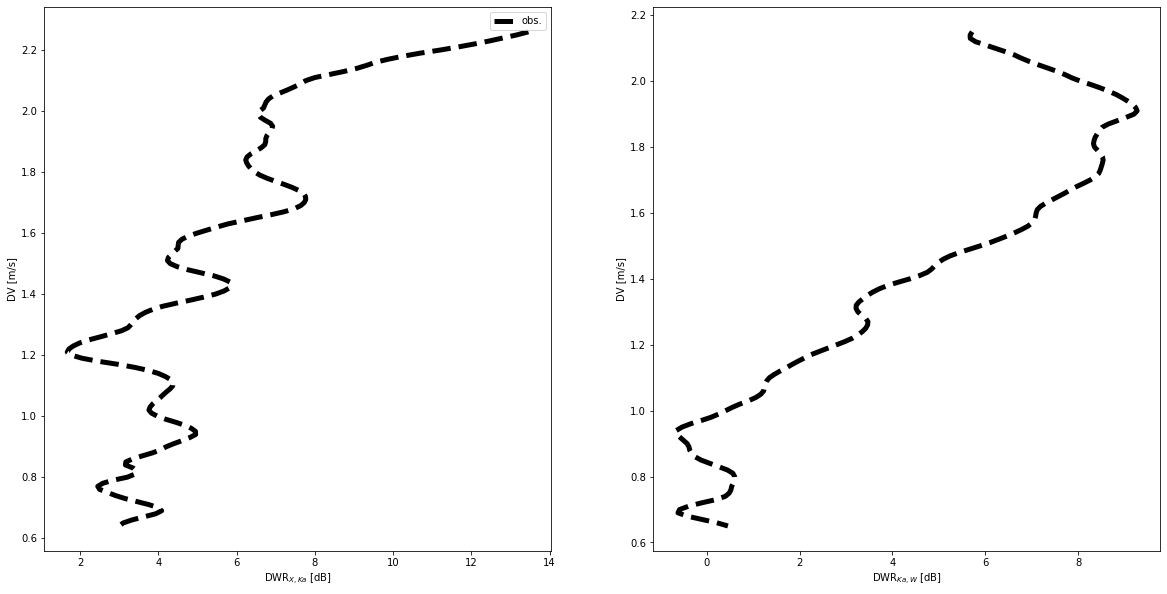

In [17]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
__ = pl.plotSDWRvsDVobs(SpecSingleWshiftedCut,axes2)

## plot average DV vs. DWR from time-height window

plot average DV vs DWR for a time-height window


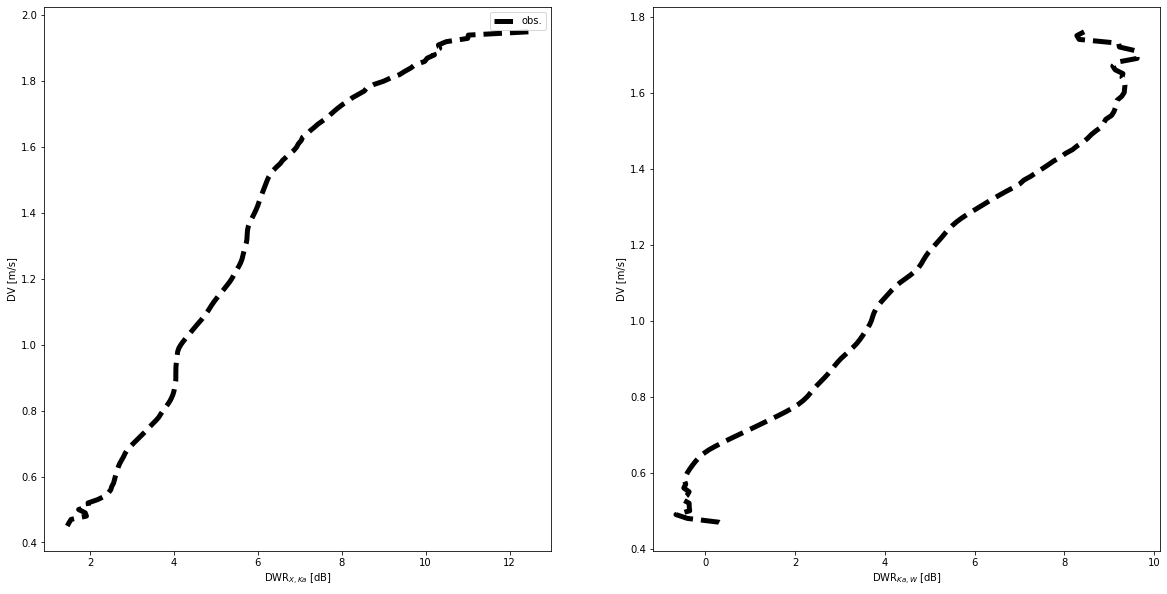

In [18]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
__ = pl.plotSDWRvsDVobs(SpecWindow,axes2)

## how do the snowscatt models fit to the observed DV-DWR relation

### mixcoldend with all riming degrees

plot average DV vs DWR for a time-height window


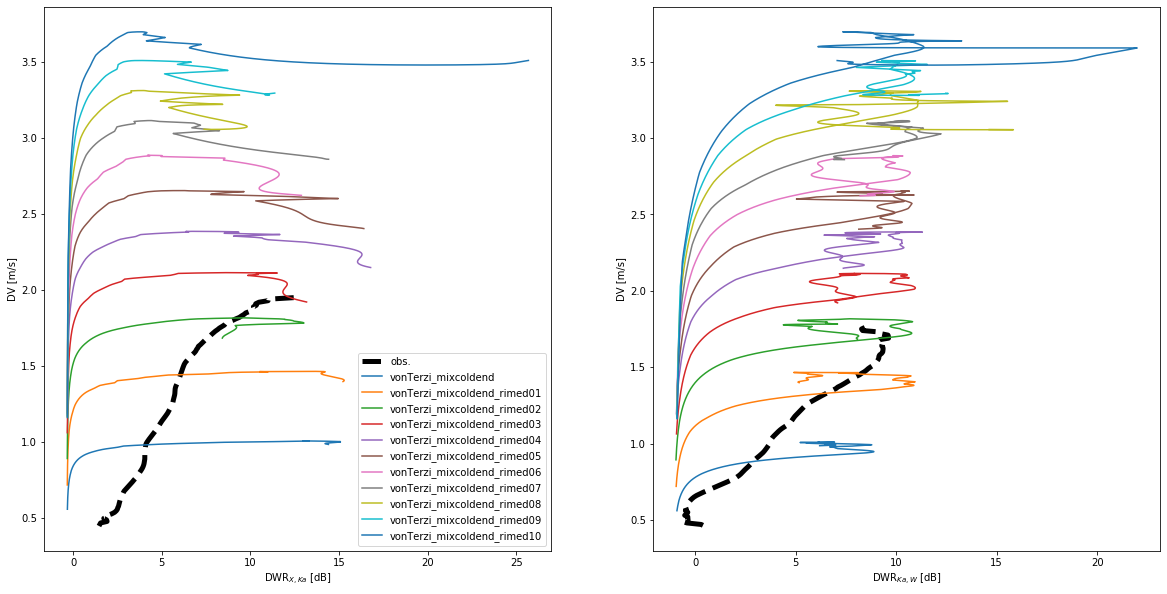

In [9]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
axes2 = pl.plotSDWRvsDVobs(SpecWindow,axes2)
#get names of all particle types
allParticleTypes        = [*snowScatt.snowLibrary._fileList.keys()]
#select an aggregate type
aggType = 'vonTerzi_mixcoldend'
#get a list of all particle-type names from this aggregate type with different riming degrees
allRimDegr = [k for k in allParticleTypes if aggType in k]
for pType in allRimDegr:
    #get spectral-resolved particle properties
    Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne(pType)
    #calculate spectral DWRs
    DWRxk = Zx-Zk; DWRkw = Zk-Zw
    axes2 = pl.plotSDWRvsDVmodel(vel,DWRxk,DWRkw,axes2,pType)
axes2[0].legend()

### all unrimed vonTerzis'

plot average DV vs DWR for a time-height window


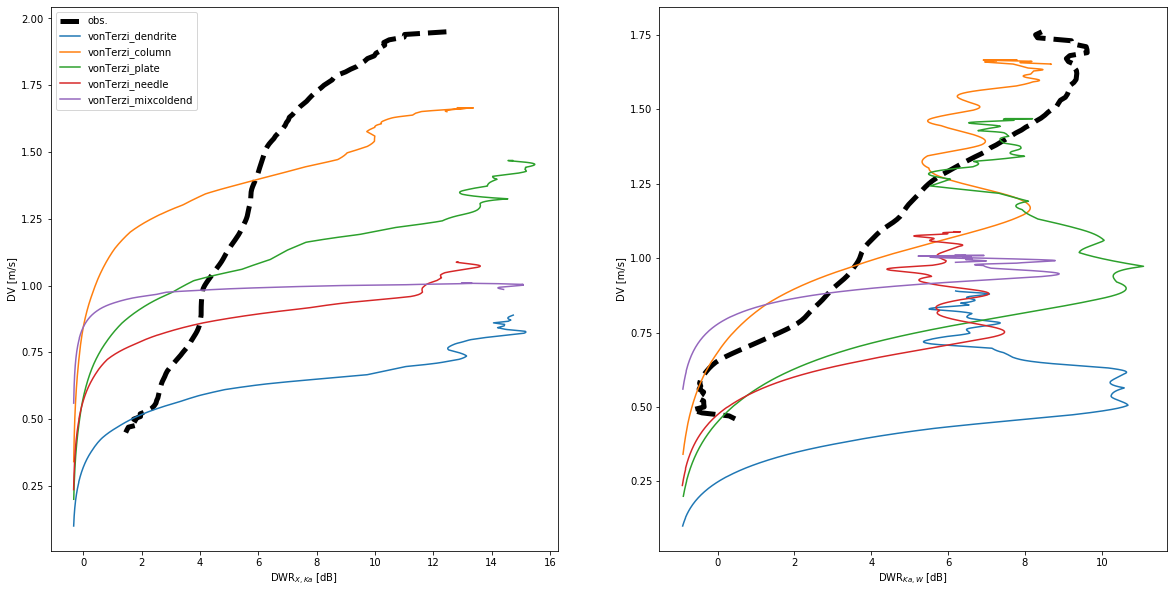

In [10]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
allParticleTypes        = [*snowScatt.snowLibrary._fileList.keys()]
axes2 = pl.plotSDWRvsDVobs(SpecWindow,axes2)
allUnrimVT = [k for k in allParticleTypes if ("vonTerzi_" in k and not "rimed" in k)]
for pType in allUnrimVT:
    #get spectral-resolved particle properties
    Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne(pType)
    #calculate spectral DWRs
    DWRxk = Zx-Zk; DWRkw = Zk-Zw
    axes2 = pl.plotSDWRvsDVmodel(vel,DWRxk,DWRkw,axes2,pType)
axes2[0].legend()

### all Leinonens' and Ori

plot average DV vs DWR for a time-height window


(0, 2)

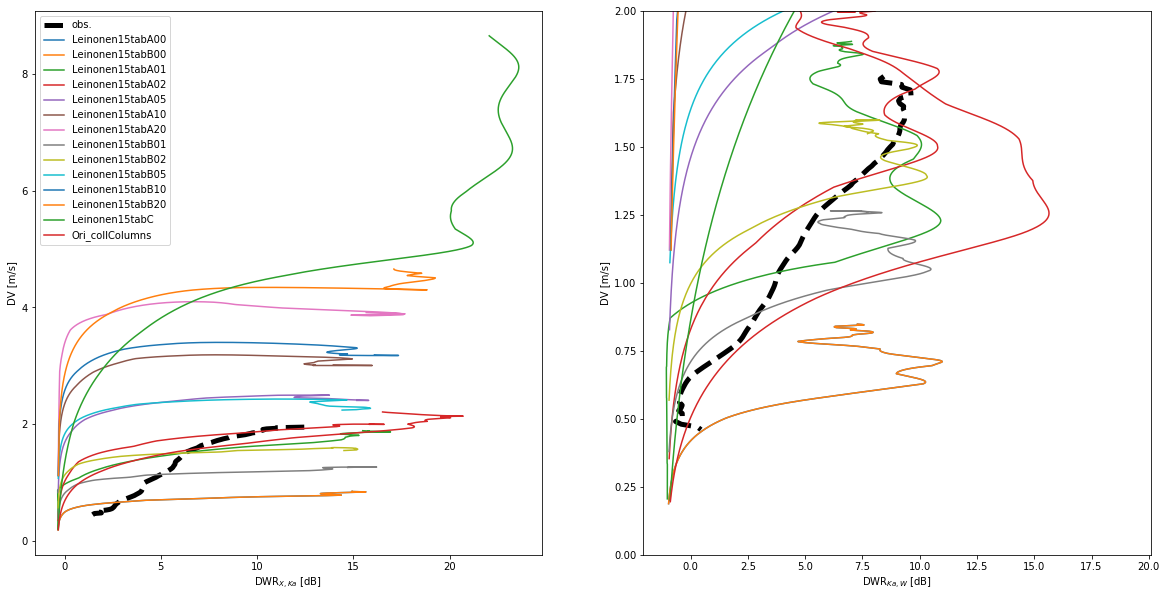

In [19]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
allParticleTypes        = [*snowScatt.snowLibrary._fileList.keys()]
axes2 = pl.plotSDWRvsDVobs(SpecWindow,axes2)
allUnrimVT = [k for k in allParticleTypes if ("Leinonen" in k or "Ori" in k)]
for pType in allUnrimVT:
    #get spectral-resolved particle properties
    Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne(pType)
    #calculate spectral DWRs
    DWRxk = Zx-Zk; DWRkw = Zk-Zw
    axes2 = pl.plotSDWRvsDVmodel(vel,DWRxk,DWRkw,axes2,pType)
axes2[0].legend()
axes2[1].set_ylim([0,2])

### find best fitting particle type

Start: find best matching particle type in DV-DWR spaces
plot average DV vs DWR for a time-height window
best Ptype: vonTerzi_column
plot average DV vs DWR for a time-height window


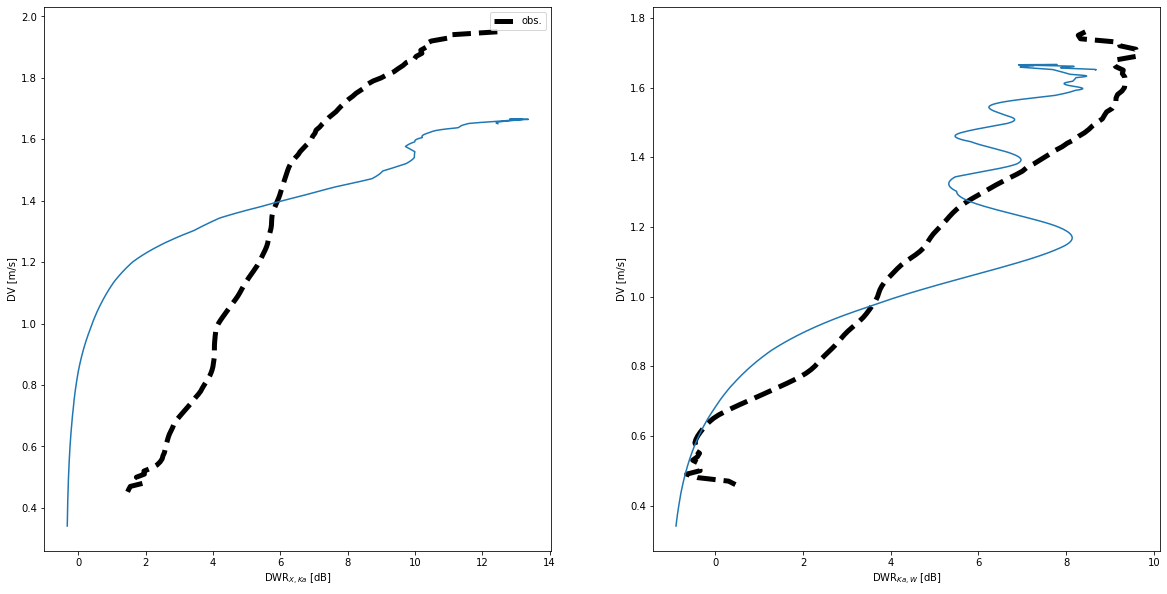

In [12]:
#should we use DWR_X_Ka, DWR_Ka_W or both?
whichDWRsToUse="DWR_Ka_W" # choose from ["both","DWR_Ka_W",""DWR_X_Ka]
#find best fitting particle type
ParticleTypeList = [*snowScatt.snowLibrary._fileList.keys()] #read https://www.python.org/dev/peps/pep-0448/ for the [*...] formalism
#ParticleTypeList = [k for k in allParticleTypes if 'vonTerzi_mixcoldend' in k]
#ParticleTypeList = ["vonTerzi_mixcoldend","vonTerzi_mixcoldend_rimed05"]
[bestPartType,orderedListPartType] = rU.findBestFittingPartType(ParticleTypeList,SpecWindow,whichDWRsToUse=whichDWRsToUse)
#plot sDWR vs DV for best fitting particle type
Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne(bestPartType)
DWRxk = Zx - Zk; DWRkw = Zk - Zw
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
axes2 = pl.plotSDWRvsDVobs(SpecWindow,axes2)
axes2 = pl.plotSDWRvsDVmodel(vel,DWRxk,DWRkw,axes2,bestPartType)

## plot mass and Ze (at Ka-Band) for each DV bin from the selected model

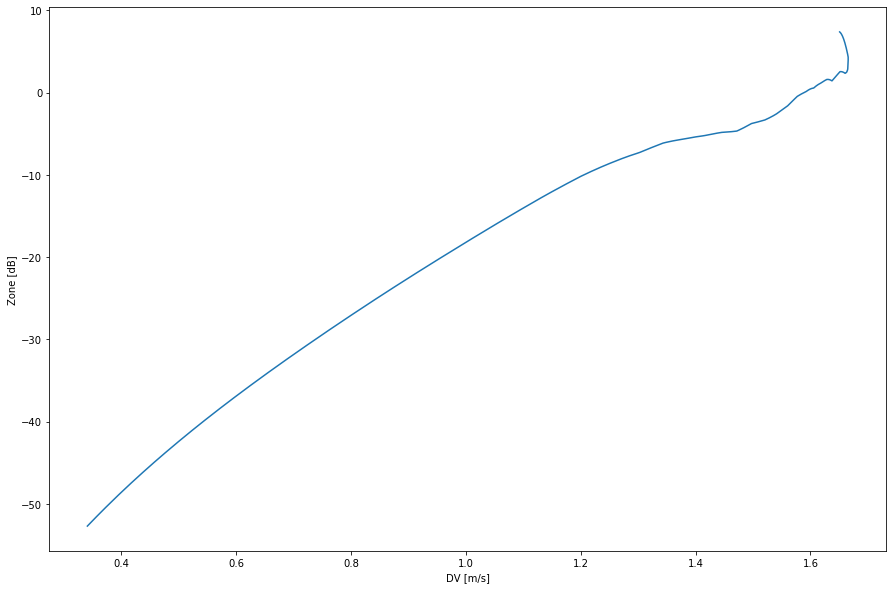

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
ax = pl.plotSinglePartZe(bestPartType,ax,freq="Ka")

## derive size distribution by dividing the observed spectral power by the single particle backscattering cross section at each DV-bin N(D)=ze/sigma_single

/usr/lib/python3/dist-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/usr/lib/python3/dist-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


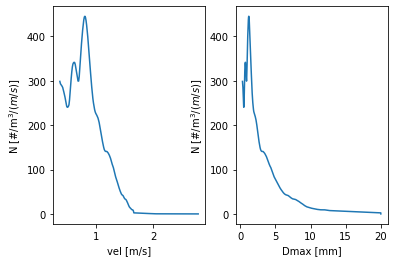

In [14]:
velObs,NumConNorm,DmaxAtObsDVgrid = rU.calculateNumberForEachDVbin(Zk,SpecSingleWshifted.KaSpecH.values,vel,-SpecSingleWshifted.KaSpecH.doppler.values,DmaxModel=Dmax)
fig,axes = plt.subplots(nrows=1,ncols=2)
axes = pl.plotNumCon(NumConNorm,axes,[velObs,DmaxAtObsDVgrid*1e3],["vel [m/s]","Dmax [mm]"])